# Zero-shot Segmenation Results Quantification

## Setup

In [8]:
# imports
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    jaccard_score,
)


In [12]:
# config
DATA_ROOT = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
PRED_ROOT = "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_zeroshot/results"

DATASETS = [
    "amyloid_plaque_patches",
    "c_fos_positive_patches",
    "cell_nucleus_patches",
    "vessels_patches",
]

MODELS = ["image_clip", "image_only", "random"]

MODEL_TITLES = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}



In [10]:
# utils

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

def dice_numpy(pred, gt, eps=1e-8):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2 * inter) / (pred.sum() + gt.sum() + eps)


In [4]:
# metric computation
rows = []

for dataset in DATASETS:
    print(f"\nProcessing dataset: {dataset}")
    gt_dir   = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*_label.nii.gz")))

    for gt_path in gt_files:
        base = os.path.basename(gt_path).replace("_label.nii.gz", "")
        gt = load_nifti(gt_path).astype(bool)

        for model in MODELS:
            pred_path = os.path.join(pred_dir, f"{base}_pred_{model}.nii.gz")
            prob_path = os.path.join(pred_dir, f"{base}_prob_{model}.nii.gz")

            if not (os.path.exists(pred_path) and os.path.exists(prob_path)):
                continue

            pred = load_nifti(pred_path).astype(bool)
            prob = load_nifti(prob_path)

            gt_flat   = gt.flatten()
            pred_flat = pred.flatten()
            prob_flat = prob.flatten()

            # Binary metrics
            dice = dice_numpy(pred, gt)
            iou  = jaccard_score(gt_flat, pred_flat)
            prec = precision_score(gt_flat, pred_flat, zero_division=0)
            rec  = recall_score(gt_flat, pred_flat, zero_division=0)

            # Threshold-free metrics
            try:
                roc = roc_auc_score(gt_flat, prob_flat)
            except ValueError:
                roc = np.nan

            try:
                pr = average_precision_score(gt_flat, prob_flat)
            except ValueError:
                pr = np.nan

            rows.append({
                "dataset": dataset,
                "patch": base,
                "model": model,
                "dice": dice,
                "iou": iou,
                "precision": prec,
                "recall": rec,
                "roc_auc": roc,
                "pr_auc": pr,
            })
            


Processing dataset: amyloid_plaque_patches

Processing dataset: c_fos_positive_patches

Processing dataset: cell_nucleus_patches

Processing dataset: vessels_patches


## Summary stats and plots

dataset       model      dice                 iou  \
                                            mean       std      mean   
0   amyloid_plaque_patches  image_clip  0.018667  0.038115  0.009800   
1   amyloid_plaque_patches  image_only  0.018854  0.039030  0.009915   
2   amyloid_plaque_patches      random  0.017752  0.034410  0.009262   
3   c_fos_positive_patches  image_clip  0.136933  0.044142  0.073950   
4   c_fos_positive_patches  image_only  0.122891  0.039003  0.065812   
5   c_fos_positive_patches      random  0.063648  0.076746  0.034108   
6     cell_nucleus_patches  image_clip  0.430934  0.097806  0.279513   
7     cell_nucleus_patches  image_only  0.429210  0.080089  0.276512   
8     cell_nucleus_patches      random  0.459700  0.097897  0.303607   
9          vessels_patches  image_clip  0.327044  0.179487  0.208445   
10         vessels_patches  image_only  0.335518  0.178050  0.214031   
11         vessels_patches      random  0.325818  0.158009  0.204420   

             precision              recall             roc_auc            \
         std      mean       std      mean       std      mean       std   
0   0.020773  0.009863  0.020991  0.662506  0.384107  0.850708  0.155043   
1   0.021372  0.010024  0.021779  0.713693  0.318880  0.894496  0.091564   
2   0.018637  0.009337  0.018895  0.733145  0.320081  0.893188  0.090611   
3   0.025405  0.075620  0.026725  0.802688  0.038247  0.903003  0.017072   
4   0.022030  0.068872  0.024357  0.697627  0.167984  0.864218  0.026109   
5   0.041640  0.042977  0.057420  0.288946  0.407143  0.667974  0.271666   
6   0.081519  0.295336  0.089264  0.862894  0.104290  0.972636  0.019526   
7   0.066888  0.293594  0.075286  0.856235  0.111359  0.971104  0.019746   
8   0.084727  0.320383  0.090730  0.864524  0.080221  0.975141  0.017044   
9   0.132304  0.708038  0.331504  0.225276  0.130696  0.899503  0.051847   
10  0.127645  0.727024  0.333092  0.242157  0.146992  0.897501  0.054367   
11  0.113916  0.715792  0.341723  0.250157  0.147096  0.896126  0.053592   

      pr_auc            
        mean       std  
0   0.022983  0.060304  
1   0.039681  0.088433  
2   0.033607  0.073259  
3   0.244843  0.068475  
4   0.137054  0.116599  
5   0.066317  0.058307  
6   0.534864  0.145163  
7   0.517223  0.142370  
8   0.554722  0.138526  
9   0.543027  0.219132  
10  0.553436  0.205880  
11  0.544184  0.204628


=== Mean Dice by dataset ===

amyloid_plaque_patches
  image_clip  : 0.019 ± 0.038
  image_only  : 0.019 ± 0.039
  random      : 0.018 ± 0.034

c_fos_positive_patches
  image_clip  : 0.137 ± 0.044
  image_only  : 0.123 ± 0.039
  random      : 0.064 ± 0.077

cell_nucleus_patches
  image_clip  : 0.431 ± 0.098
  image_only  : 0.429 ± 0.080
  random      : 0.460 ± 0.098

vessels_patches
  image_clip  : 0.327 ± 0.179
  image_only  : 0.336 ± 0.178
  random      : 0.326 ± 0.158


<Figure size 1000x3000 with 0 Axes>

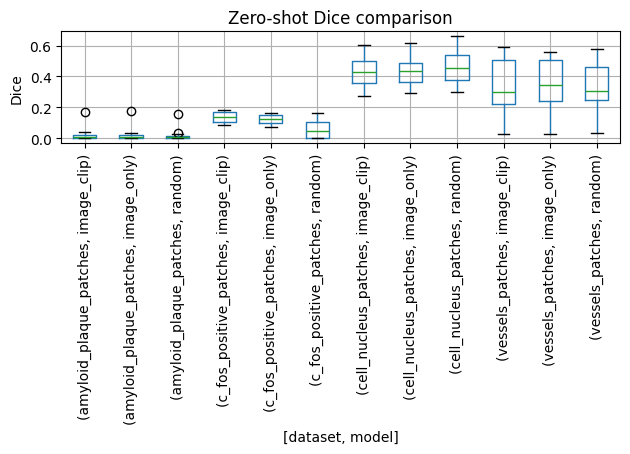

In [5]:
# create results dataframe
df = pd.DataFrame(rows)

# aggregate summary
metric_cols = [
    "dice",
    "iou",
    "precision",
    "recall",
    "roc_auc",
    "pr_auc",
]

summary = (
    df
    .groupby(["dataset", "model"])[metric_cols]
    .agg(["mean", "std"])
    .reset_index()
)

display(summary)

# print mean dice by dataset
print("\n=== Mean Dice by dataset ===")
for dataset in DATASETS:
    print(f"\n{dataset}")
    sub = df[df["dataset"] == dataset]
    for model in MODELS:
        m = sub[sub["model"] == model]["dice"]
        print(f"  {model:12s}: {m.mean():.3f} ± {m.std():.3f}")

# boxplot visualization
plt.figure(figsize=(10,30))
df.boxplot(column="dice", by=["dataset", "model"], rot=90)
plt.title("Zero-shot Dice comparison")
plt.suptitle("")
plt.ylabel("Dice")
plt.tight_layout()
plt.show()


### Boxplots

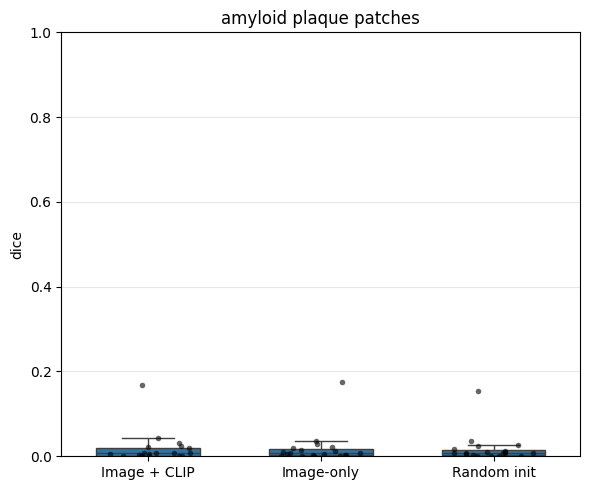

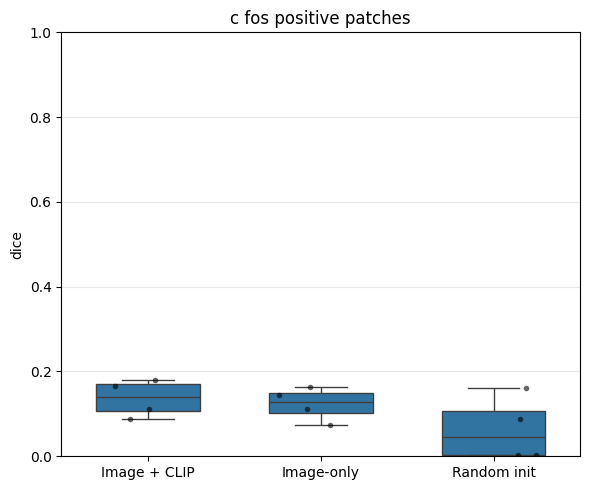

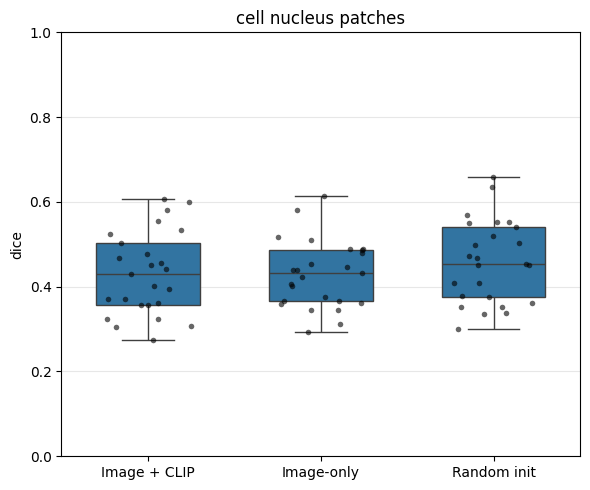

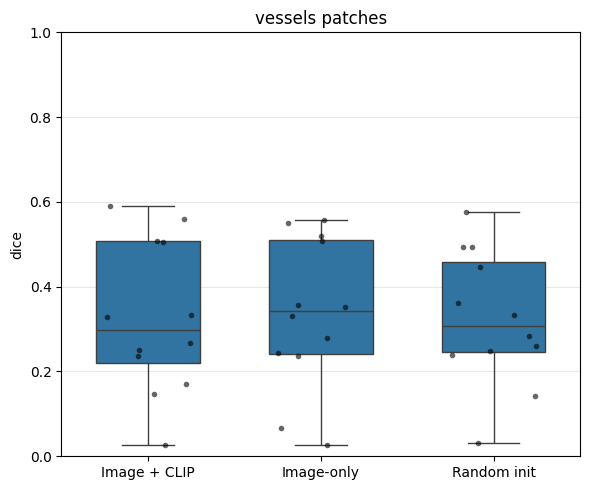

In [6]:
# Consistent ordering across plots
MODEL_ORDER = ["image_clip", "image_only", "random"]

# Optional: nicer model labels
MODEL_LABELS = {
    "image_clip": "Image + CLIP",
    "image_only": "Image-only",
    "random": "Random init",
}

def boxplot_with_points_per_dataset(df, metric="dice", save_dir=None):
    datasets = sorted(df["dataset"].unique())

    for dataset in datasets:
        sub = df[df["dataset"] == dataset].copy()

        plt.figure(figsize=(6, 5))

        # Boxplot
        sns.boxplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            showfliers=False,
            width=0.6,
        )

        # Overlay individual points
        sns.stripplot(
            data=sub,
            x="model",
            y=metric,
            order=MODEL_ORDER,
            color="black",
            alpha=0.6,
            jitter=0.25,
            size=4,
        )

        # Labels and formatting
        plt.title(f"{dataset.replace('_', ' ')}")
        plt.xlabel("")
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.grid(axis="y", alpha=0.3)

        # Replace x-axis labels with nicer names
        plt.xticks(
            ticks=range(len(MODEL_ORDER)),
            labels=[MODEL_LABELS[m] for m in MODEL_ORDER],
        )

        plt.tight_layout()

        # Optional save
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            out_path = os.path.join(
                save_dir, f"{dataset}_{metric}_boxplot.png"
            )
            plt.savefig(out_path, dpi=300)
            print(f"Saved: {out_path}")

        plt.show()


# ---------
# Run it
# ---------
boxplot_with_points_per_dataset(df, metric="dice")


## Visualize examples

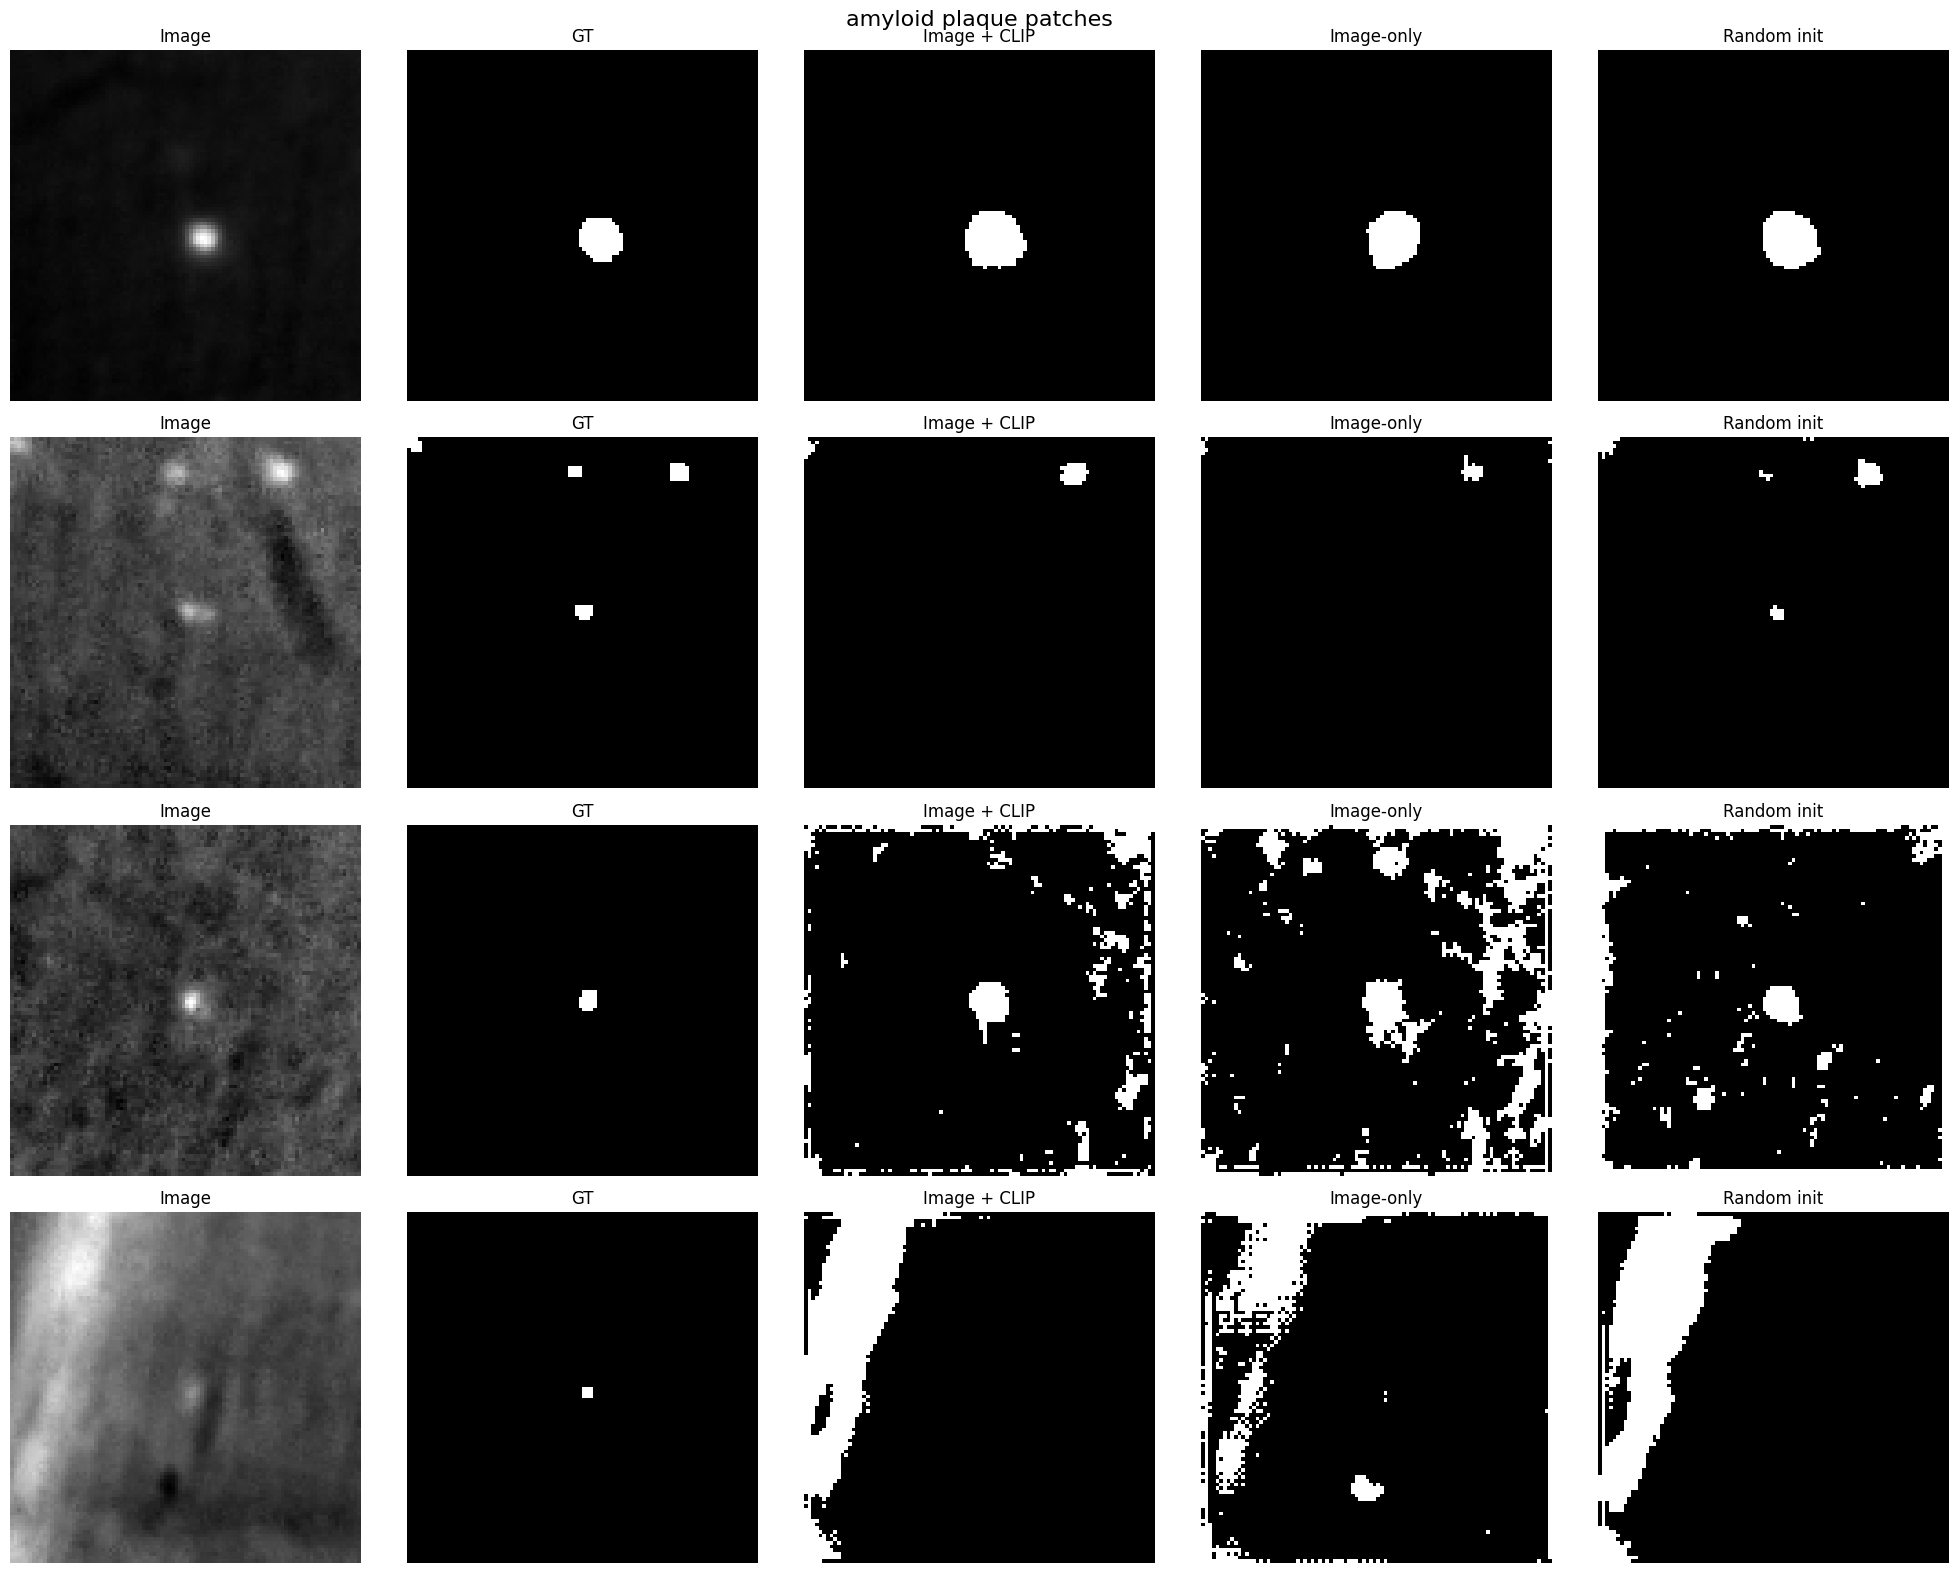

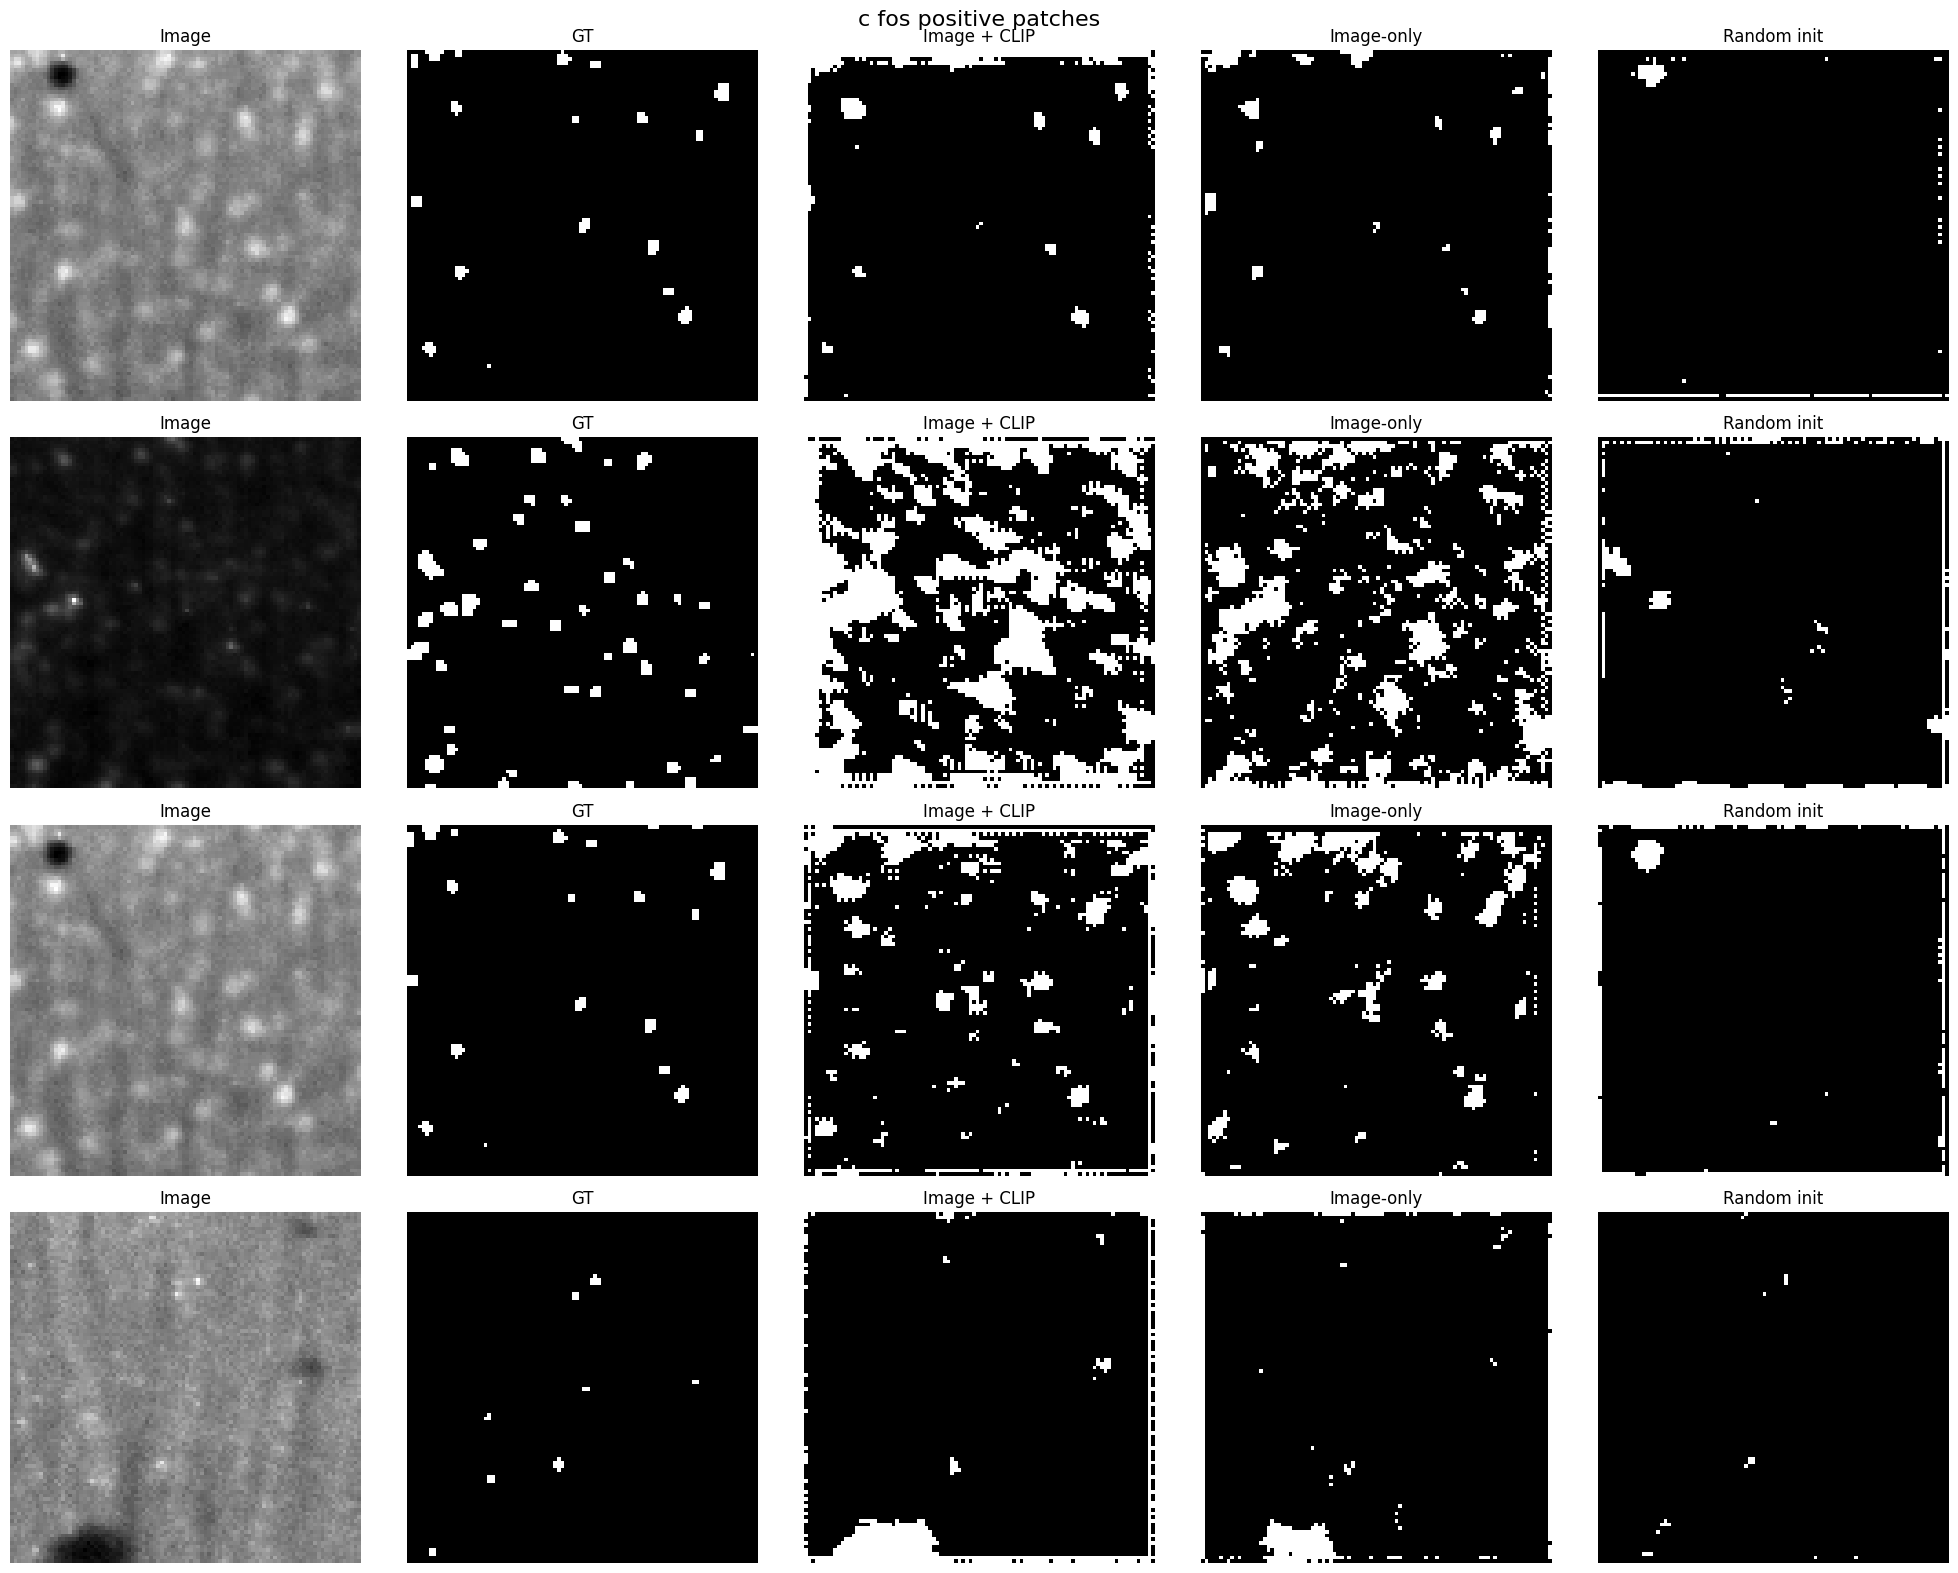

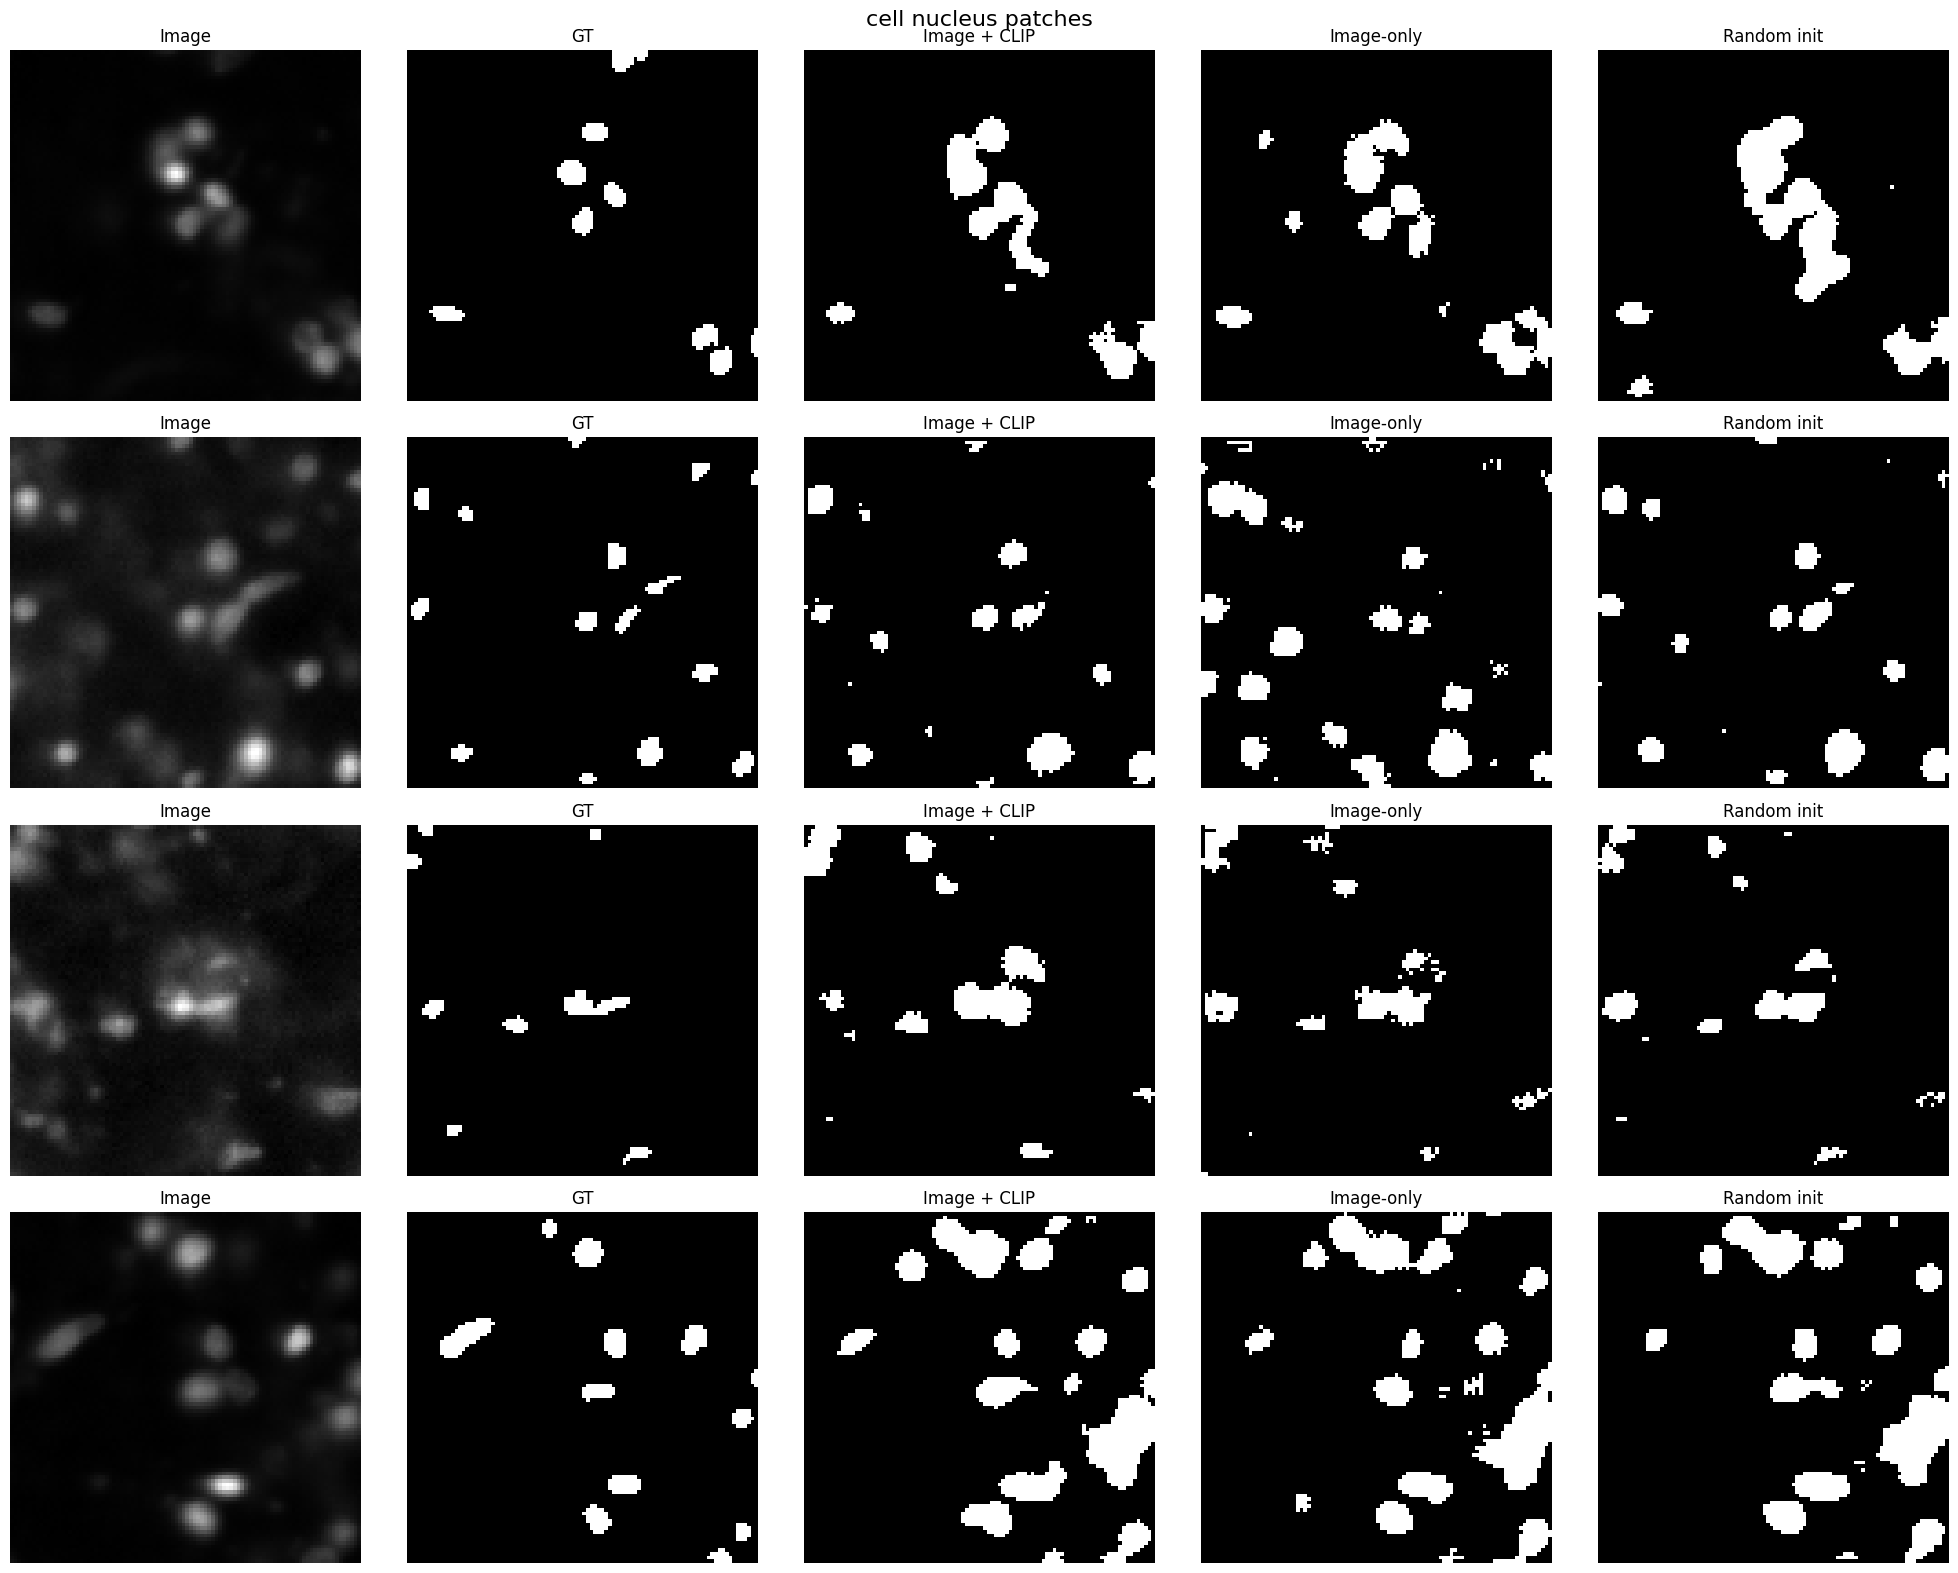

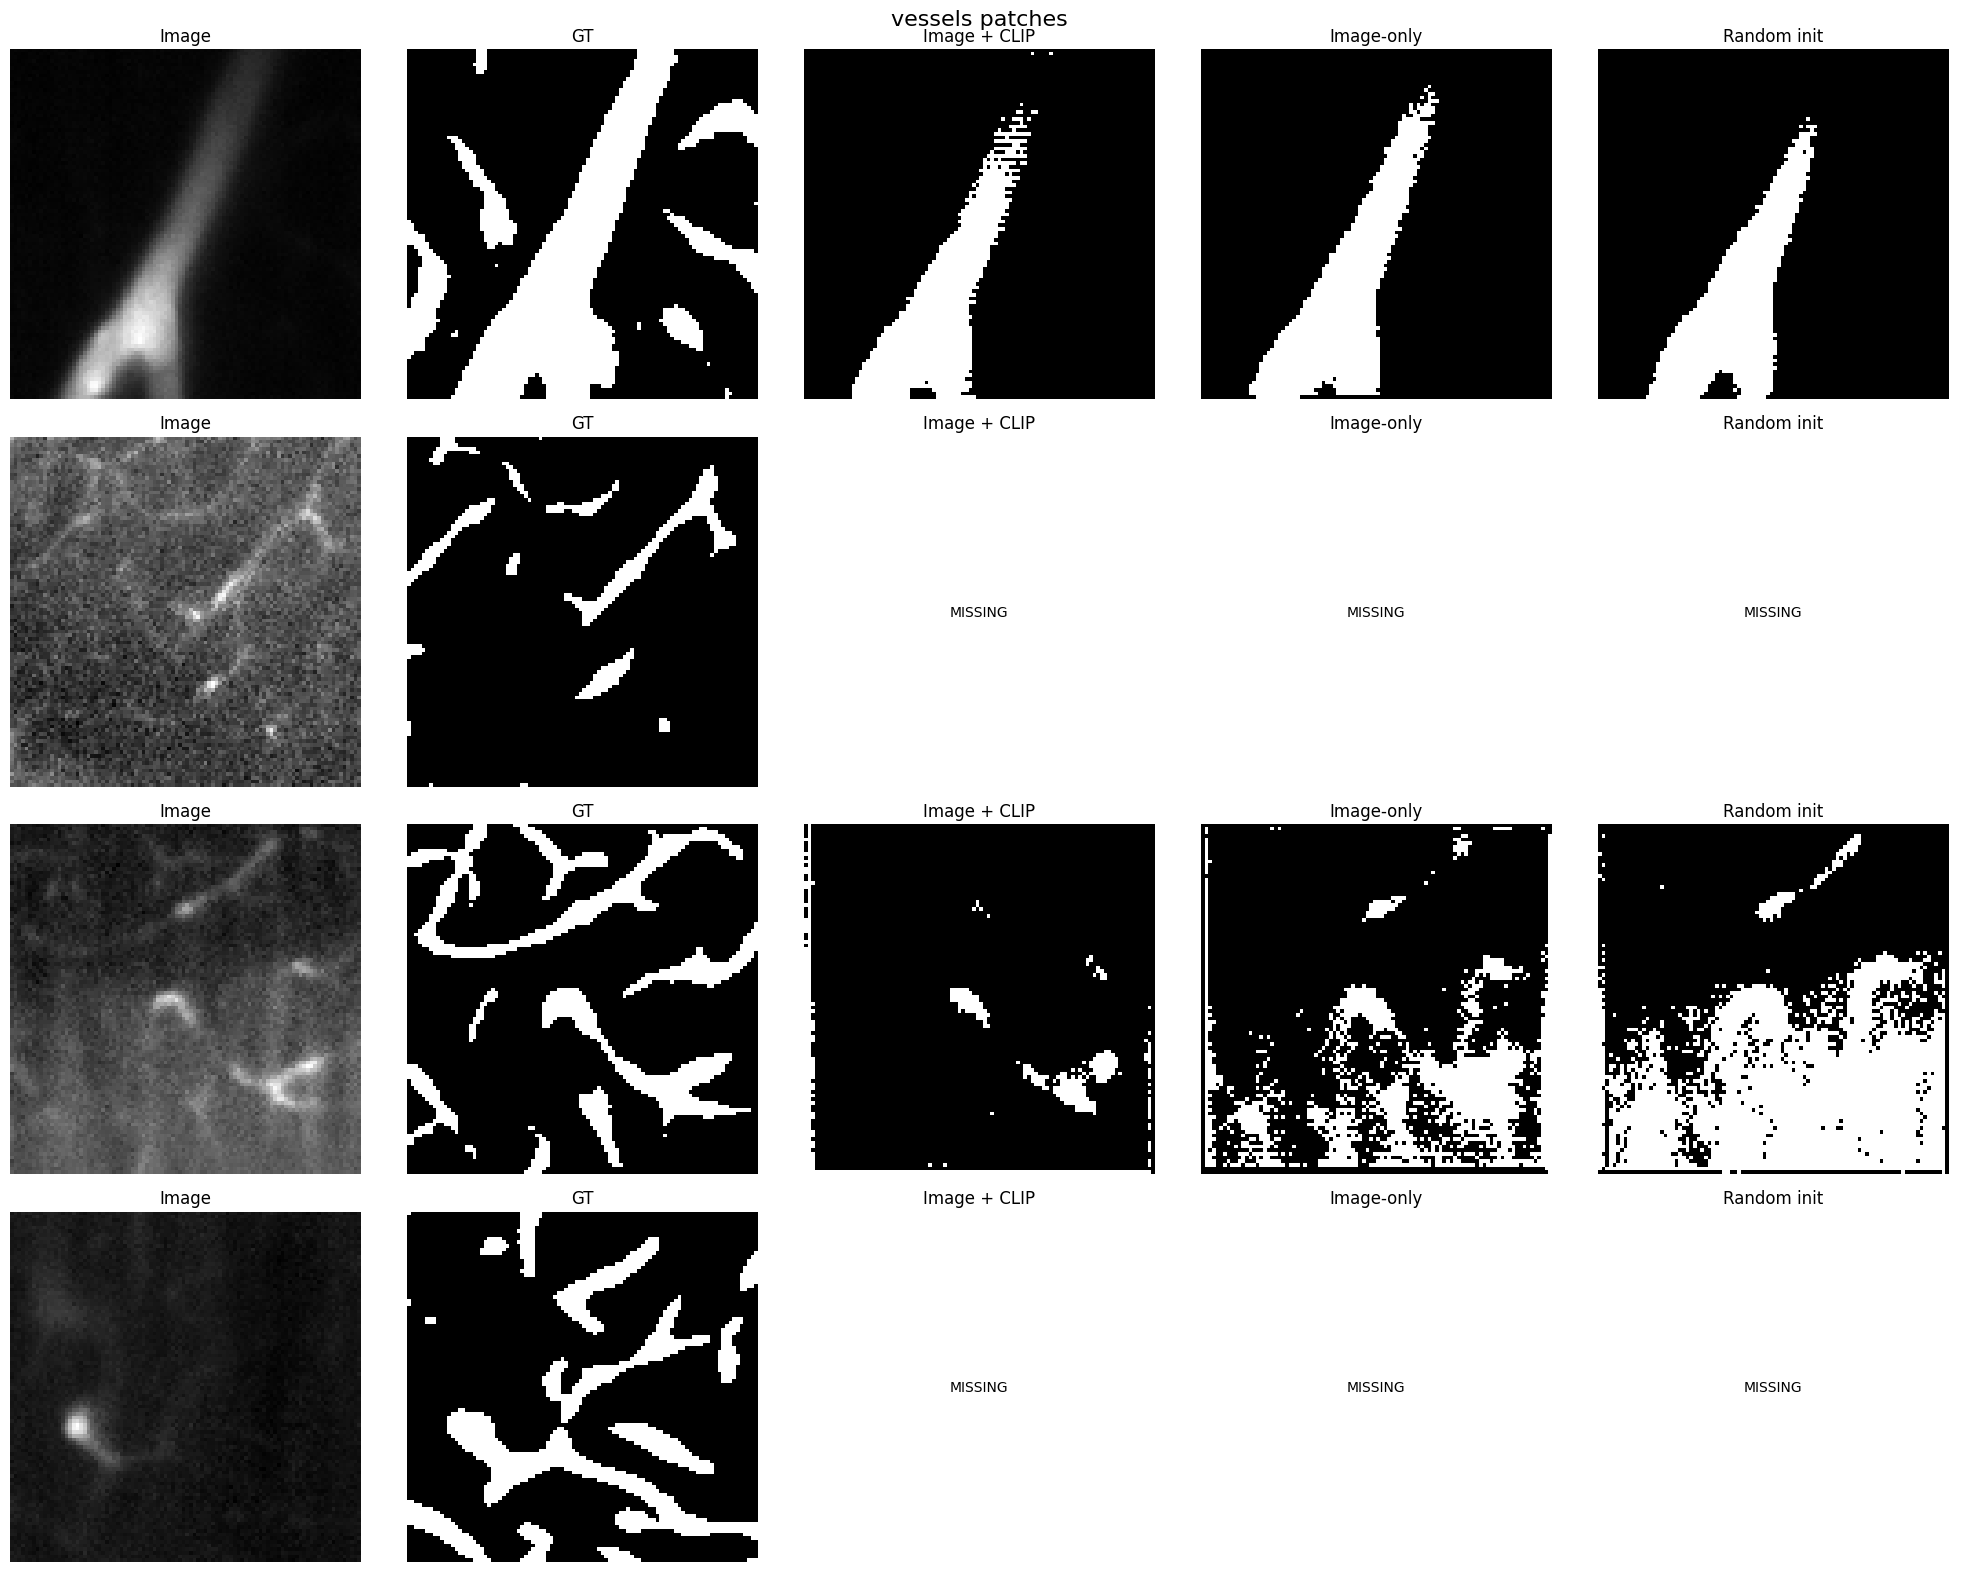

In [13]:
# visualize random examples

def show_random_examples(dataset, n_examples=4, seed=0):
    random.seed(seed)

    img_dir  = os.path.join(DATA_ROOT, dataset)
    pred_dir = os.path.join(PRED_ROOT, dataset)

    img_files = sorted(
        f for f in glob.glob(os.path.join(img_dir, "*.nii.gz"))
        if not f.endswith("_label.nii.gz")
    )

    chosen = random.sample(img_files, min(n_examples, len(img_files)))

    n_cols = 2 + len(MODELS)  # image + GT + preds
    fig, axes = plt.subplots(
        nrows=len(chosen),
        ncols=n_cols,
        figsize=(4*n_cols, 4*len(chosen))
    )

    if len(chosen) == 1:
        axes = axes[None, :]  # keep 2D indexing

    for row, img_path in enumerate(chosen):
        base = os.path.basename(img_path).replace(".nii.gz", "")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(os.path.join(img_dir, f"{base}_label.nii.gz"))

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title("Image")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                pred_dir, f"{base}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(dataset.replace("_", " "), fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_random_examples(dataset, n_examples=4, seed=100)


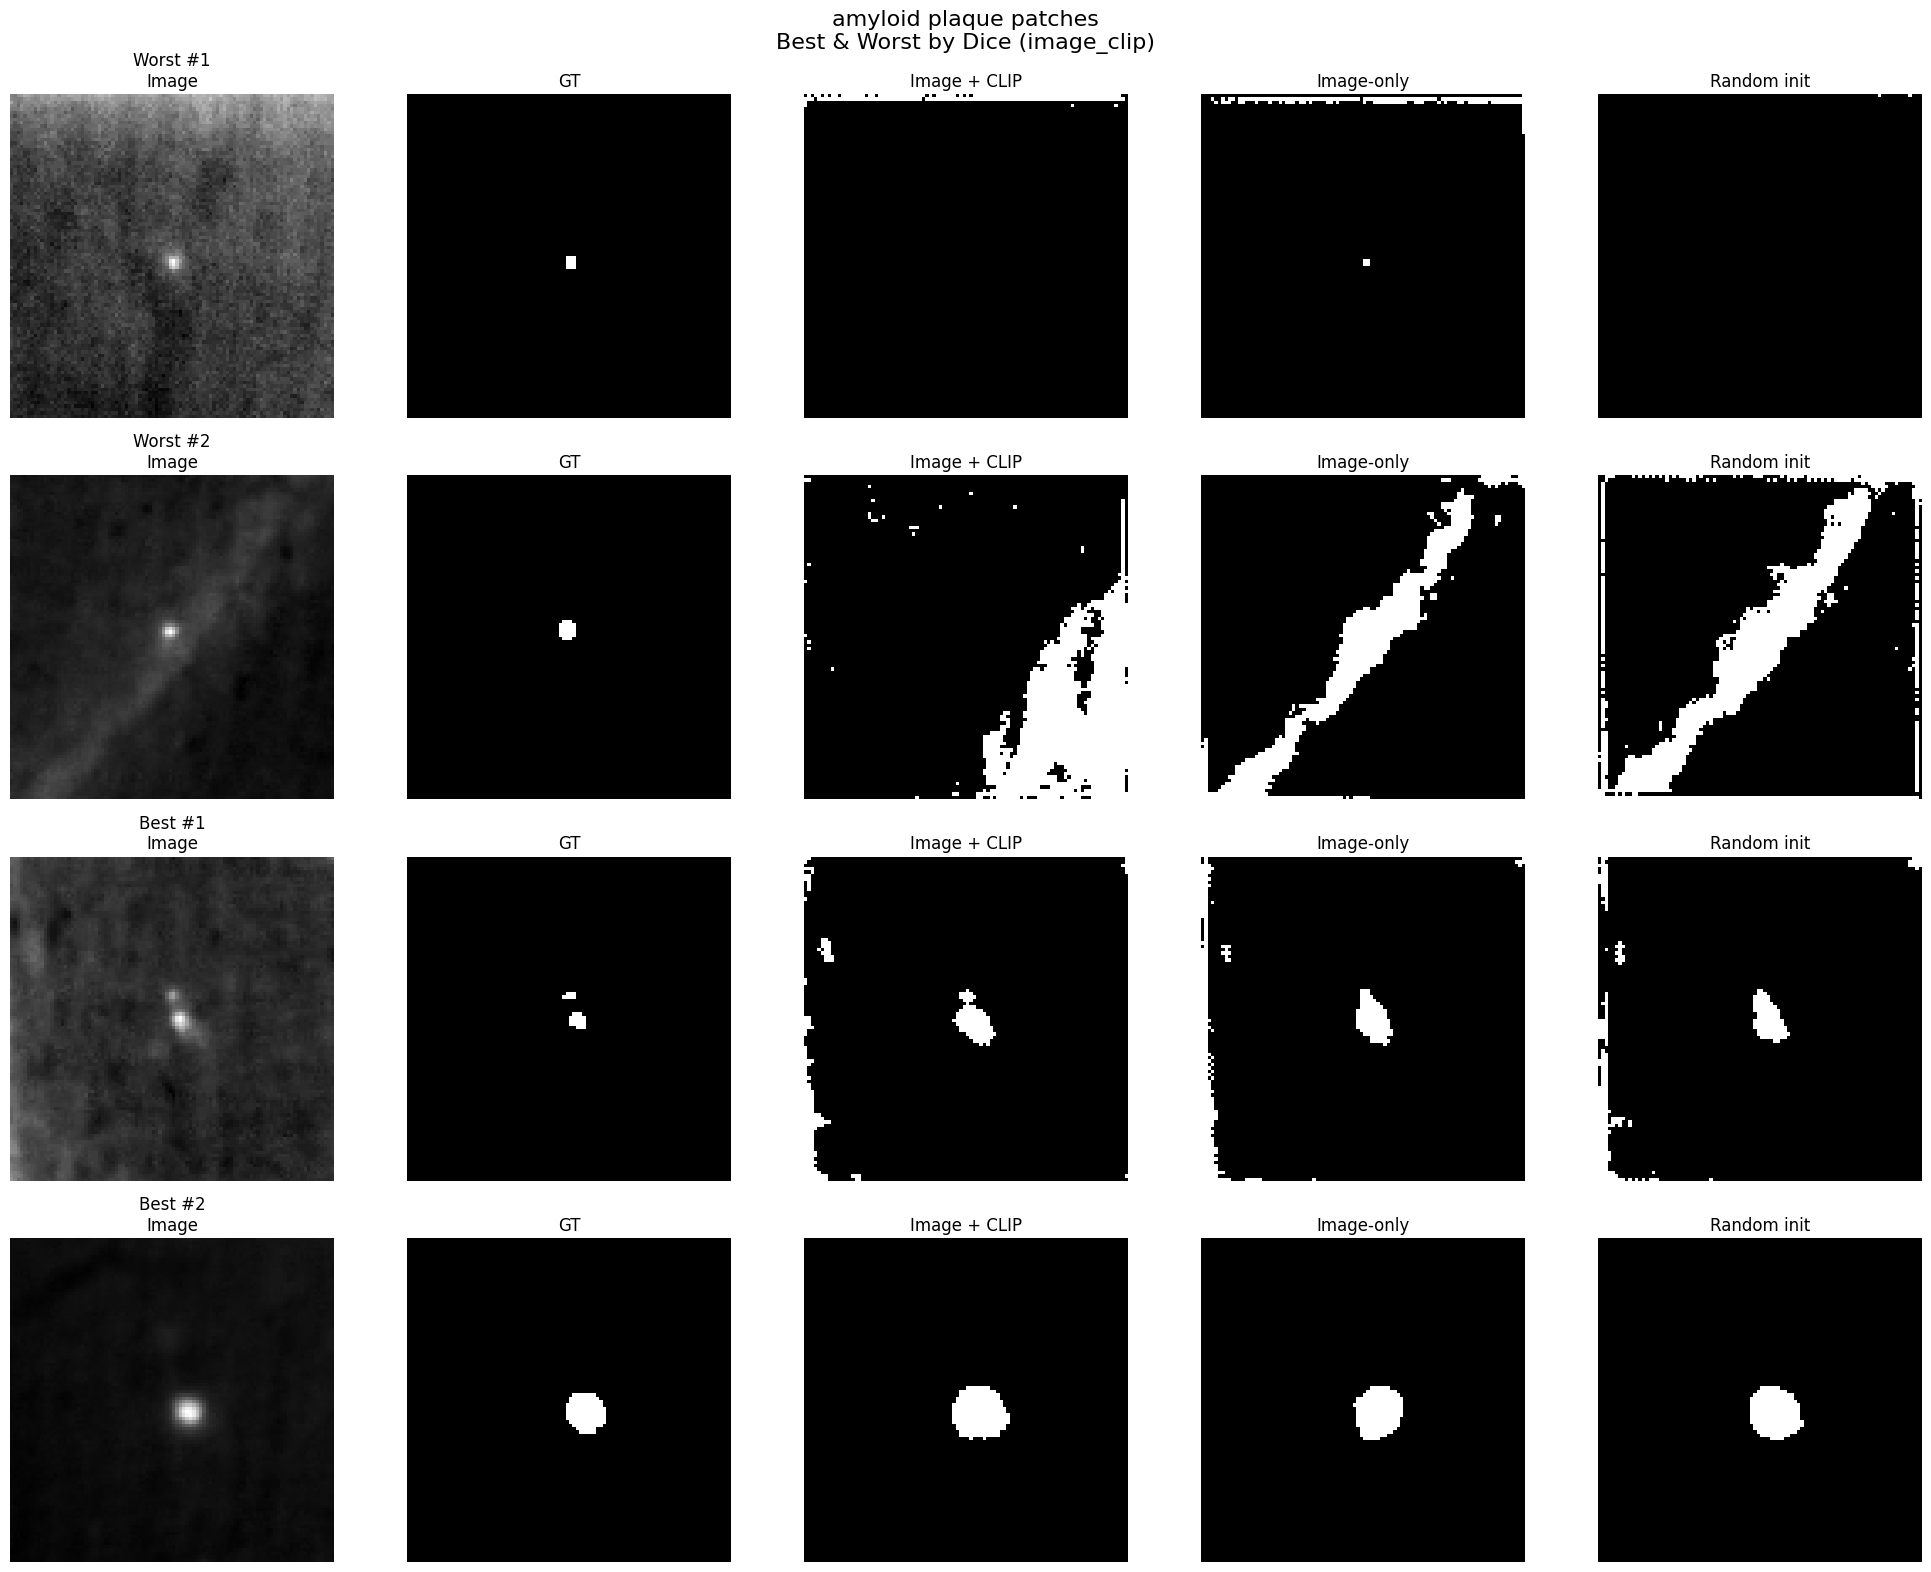

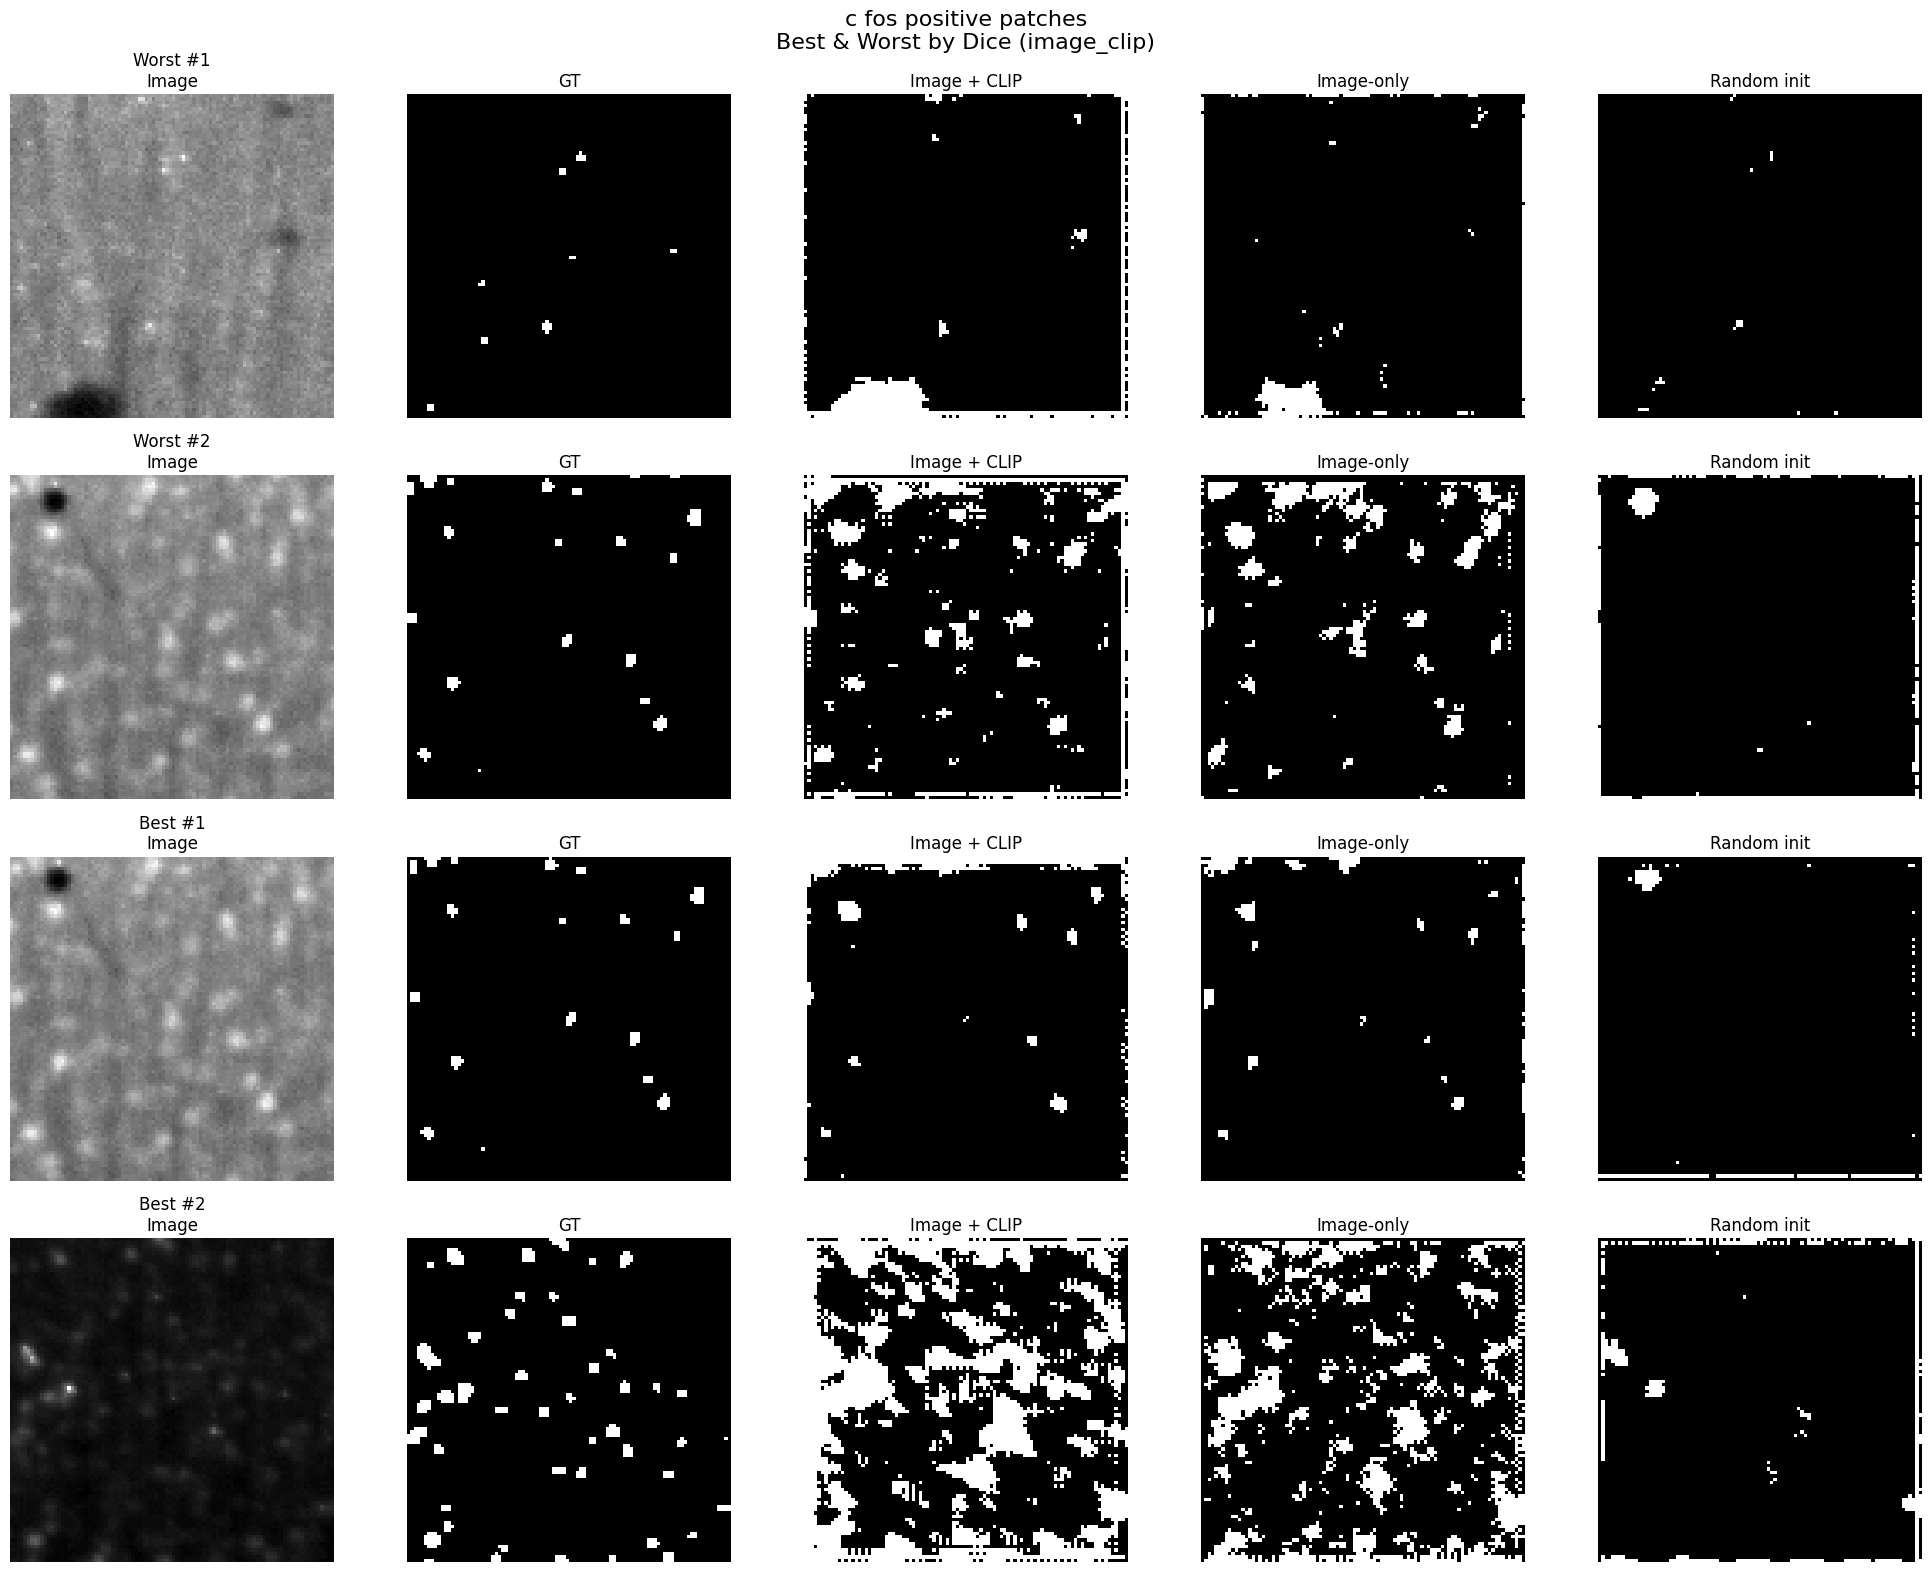

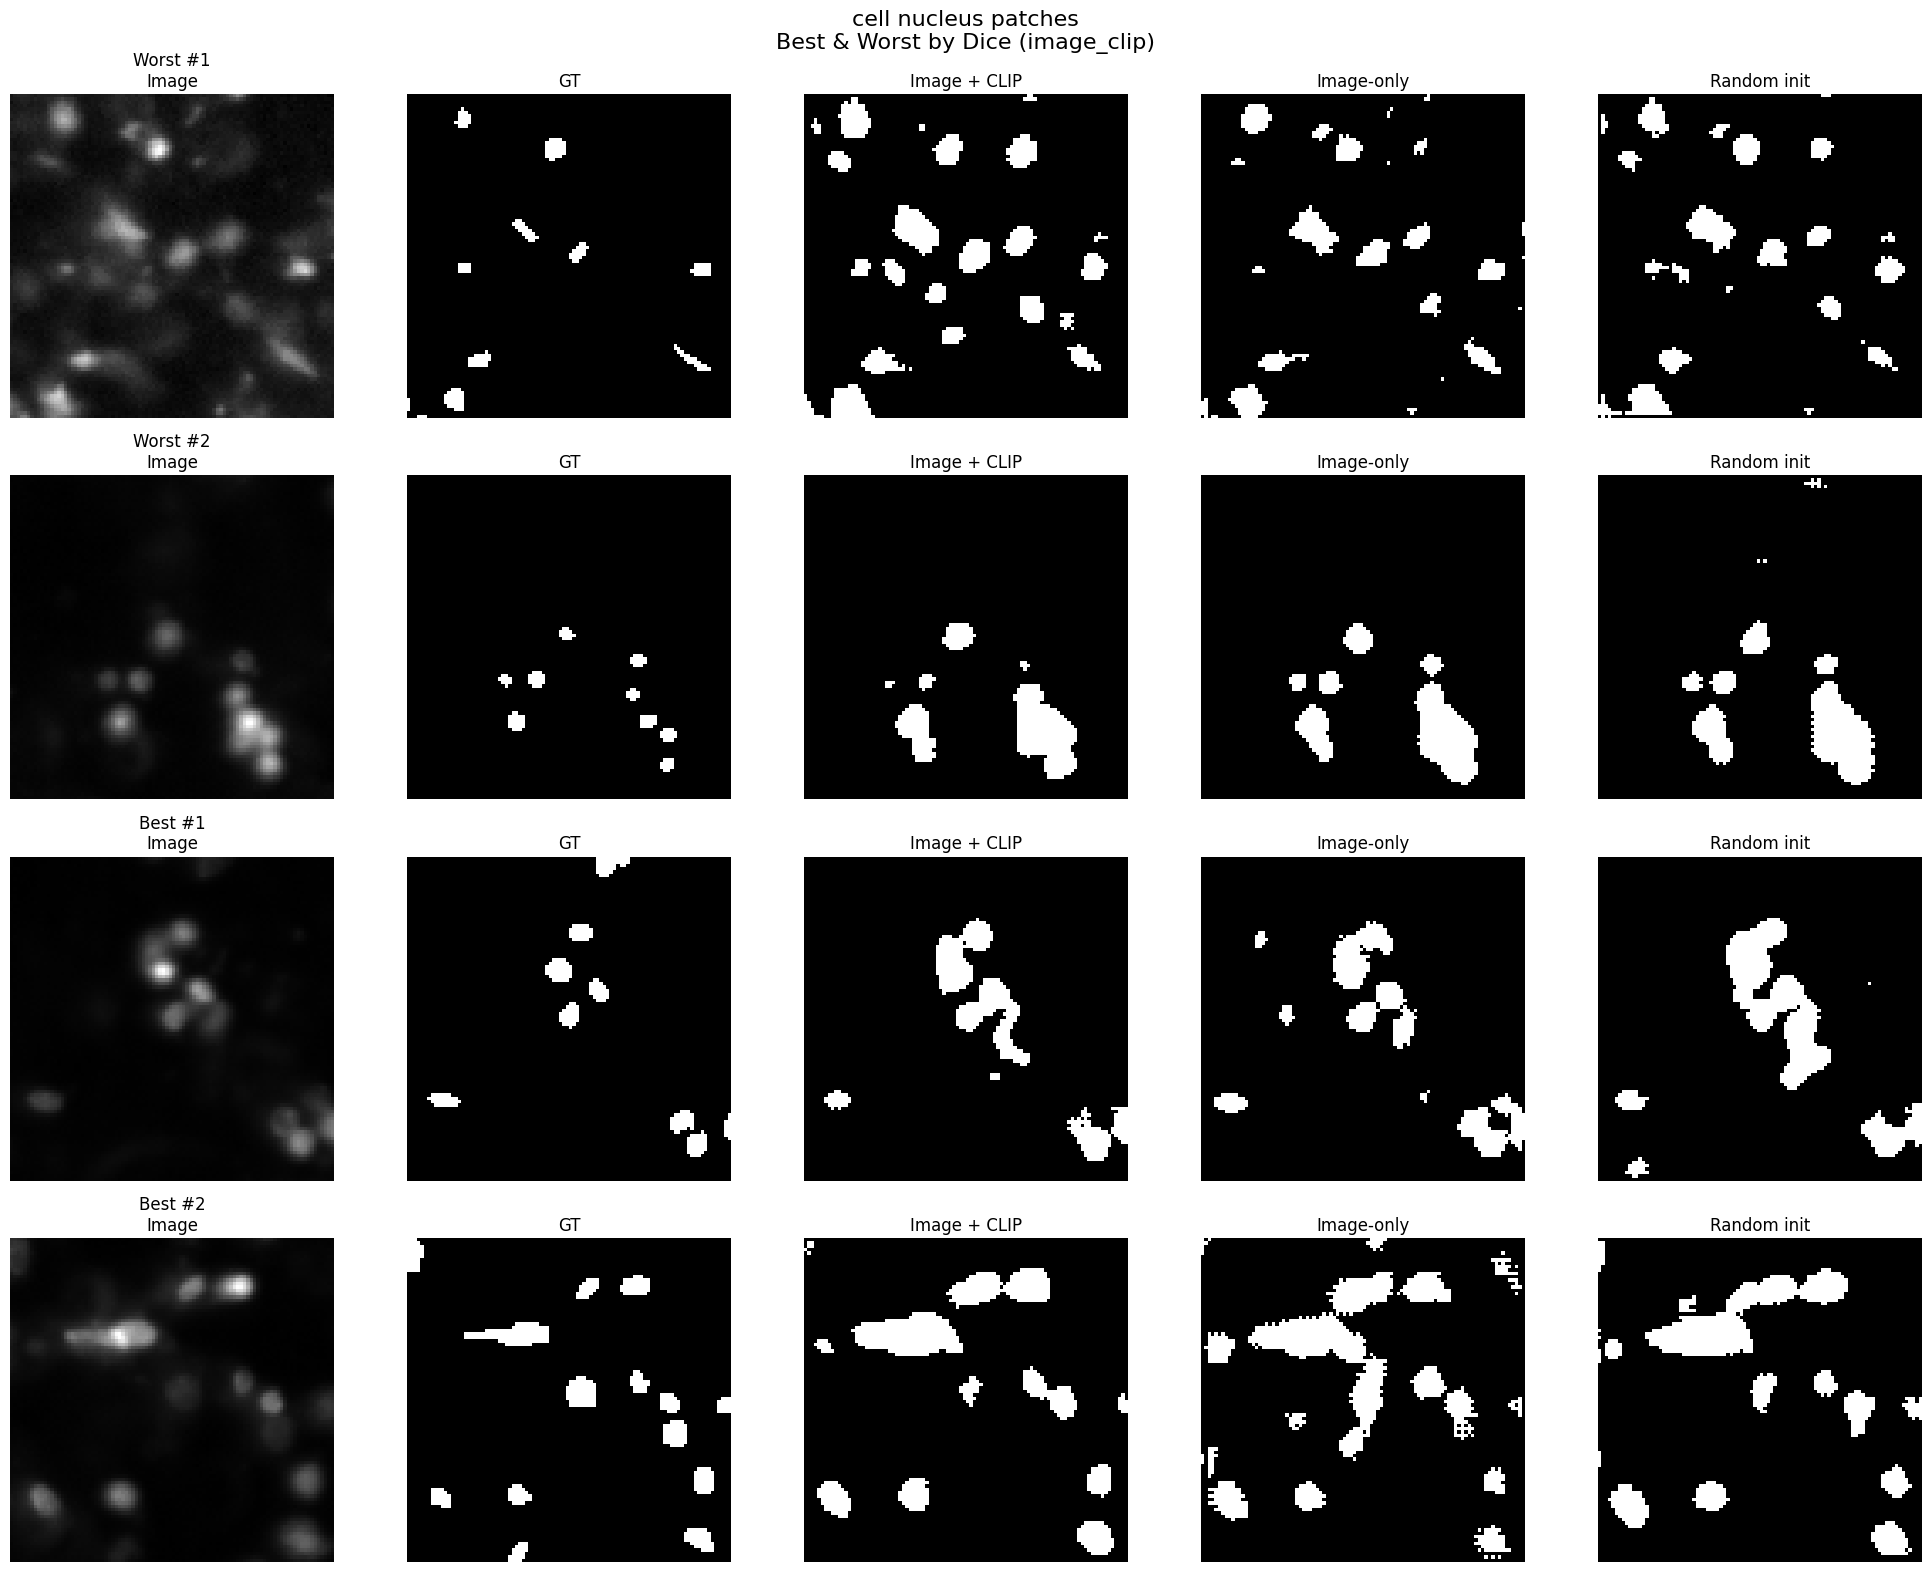

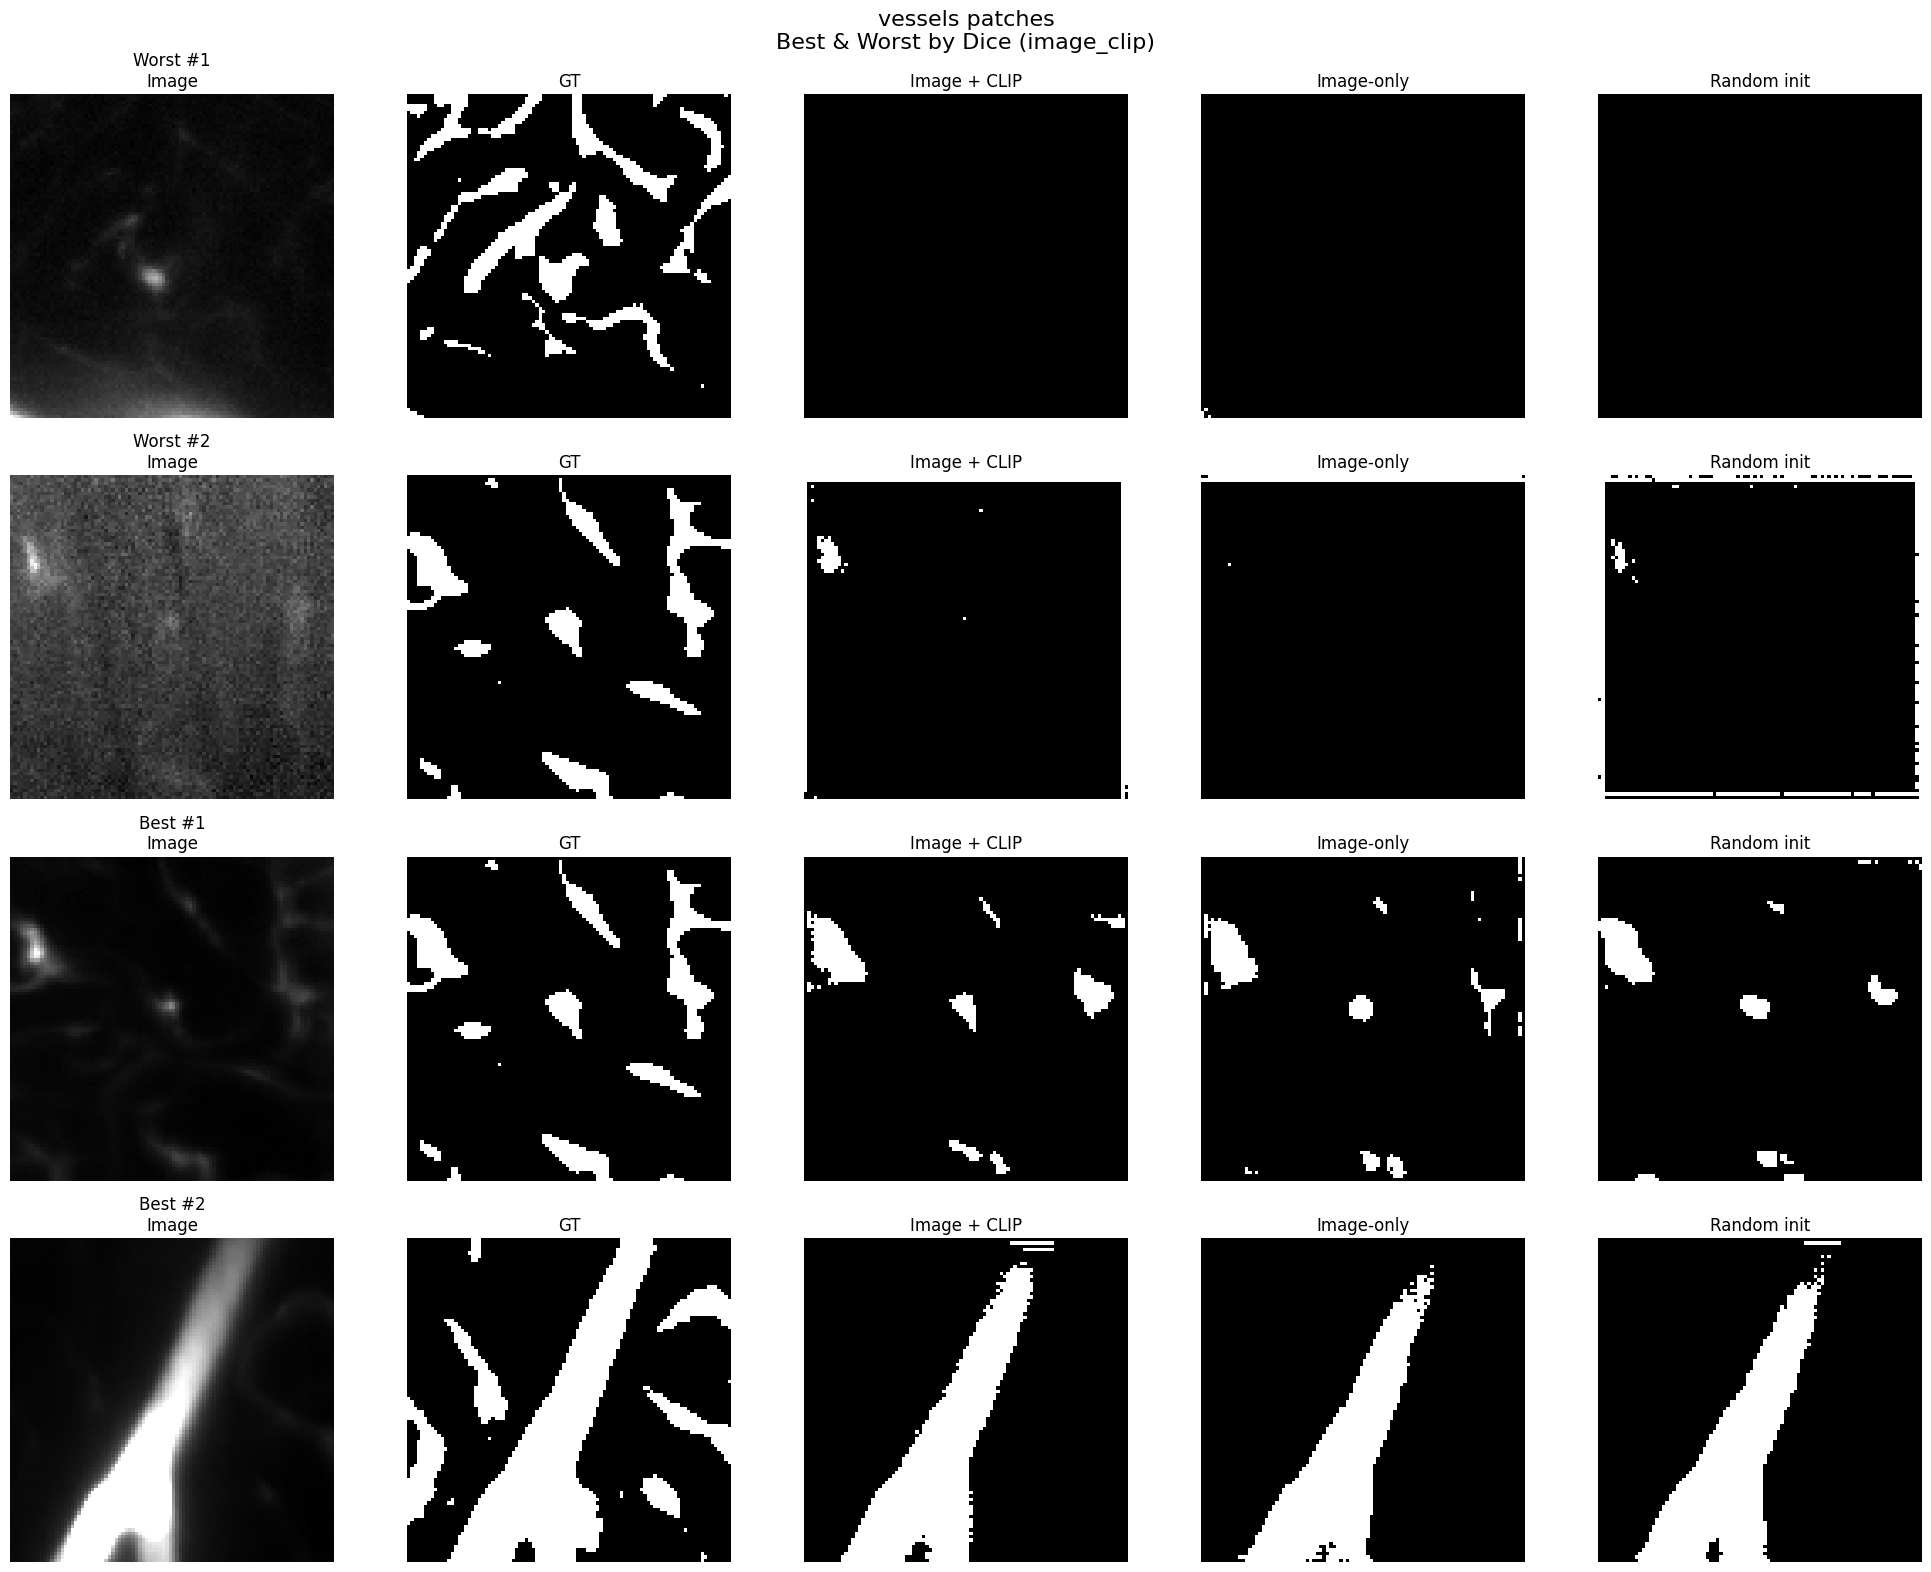

In [15]:
# visualize best/worst examples

RANK_MODEL = "image_clip"   # <<< change here if desired
N_SHOW = 2                  # best 2 + worst 2

def show_best_worst(df, dataset):
    sub = df[(df["dataset"] == dataset) & (df["model"] == RANK_MODEL)]

    # Sort patches by Dice
    sub_sorted = sub.sort_values("dice")

    worst = sub_sorted.head(N_SHOW)
    best  = sub_sorted.tail(N_SHOW)

    selected = (
        list(worst["patch"].values) +
        list(best["patch"].values)
    )

    titles = (
        [f"Worst #{i+1}" for i in range(N_SHOW)] +
        [f"Best #{i+1}" for i in range(N_SHOW)]
    )

    n_rows = len(selected)
    n_cols = 2 + len(MODELS)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(4*n_cols, 4*n_rows)
    )

    for row, (patch, title) in enumerate(zip(selected, titles)):
        img_path = os.path.join(DATA_ROOT, dataset, f"{patch}.nii.gz")
        gt_path  = os.path.join(DATA_ROOT, dataset, f"{patch}_label.nii.gz")

        img = normalize(load_nifti(img_path))
        gt  = load_nifti(gt_path)

        z = img.shape[-1] // 2

        # ---- Image ----
        axes[row, 0].imshow(img[:, :, z], cmap="gray")
        axes[row, 0].set_title(f"{title}\nImage")

        # ---- Ground truth ----
        axes[row, 1].imshow(gt[:, :, z], cmap="gray")
        axes[row, 1].set_title("GT")

        # ---- Predictions ----
        for col, model in enumerate(MODELS):
            pred_path = os.path.join(
                PRED_ROOT,
                dataset,
                f"{patch}_pred_{model}.nii.gz"
            )

            if os.path.exists(pred_path):
                pred = load_nifti(pred_path)
                axes[row, 2+col].imshow(pred[:, :, z], cmap="gray")
            else:
                axes[row, 2+col].text(
                    0.5, 0.5, "MISSING",
                    ha="center", va="center"
                )

            axes[row, 2+col].set_title(MODEL_TITLES[model])

        for a in axes[row]:
            a.axis("off")

    plt.suptitle(
        f"{dataset.replace('_', ' ')}\n"
        f"Best & Worst by Dice ({RANK_MODEL})",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run for all datasets
# -----------------------------
for dataset in DATASETS:
    show_best_worst(df, dataset)